#Introduction

Here we apply a fixed filter in order to try to "smooth" the values of the time series for the training phase.

First we did an attempt with a samller window and then we tried to increase it. This notebook shows the last version. We didn't submit it since we thought it was performing wrose with respect to the one with a window of 90, looking at the local performances.

# Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/MyDrive/Challenge2_Mio

/gdrive/MyDrive/Challenge2_Mio


In [ ]:
!pip install keras-self-attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.50.0-py3-none-any.whl size=19414 sha256=45df8415f89887ae89ea36b2a90dc5d31267e85840a5d7f3879fdf631fd4a748
  Stored in directory: /root/.cache/pip/wheels/92/7a/a3/231bef5803298e7ec1815215bc0613239cb1e9c03c57b13c14
Successfully built keras-self-attention


# Import libraries

In [ ]:
title = 'LargerWindow' #used to save models and checkpoint. Assumes in the current folder, you have a folder called "Models"

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention

warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Exploration Data Analysis (EDA)


Load the dataset

In [ ]:
dataset = pd.read_csv('Training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


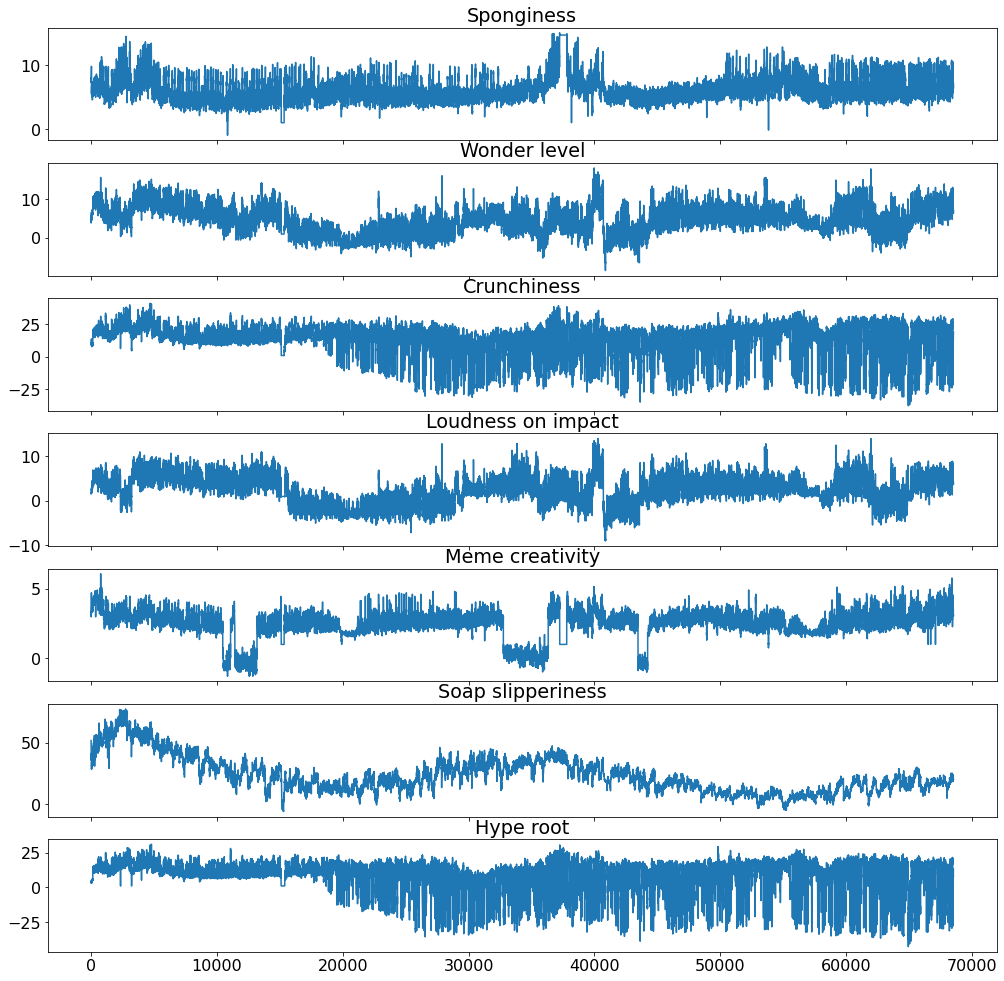

In [ ]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

Sequential Train-Test split and normalization

In [ ]:
print((dataset.shape))

(68528, 7)


(63528, 7) (5000, 7)


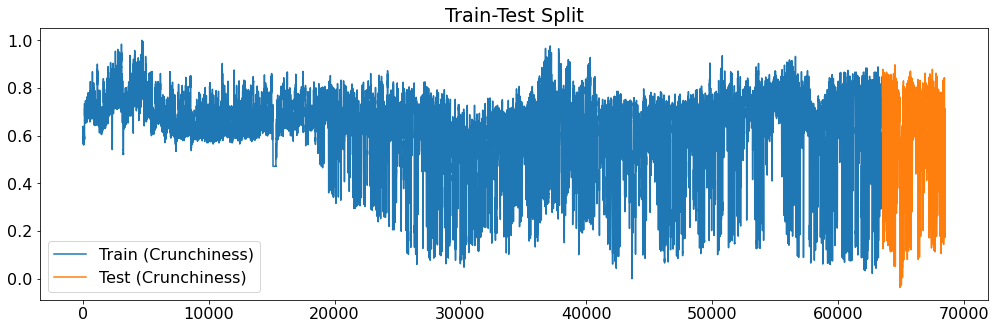

In [ ]:
test_size = 5000
X_train_raw = dataset.iloc[:-test_size]
# y_train_raw = y.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]

# y_test_raw = y.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Crunchiness, label='Train (Crunchiness)')
plt.plot(X_test_raw.Crunchiness, label='Test (Crunchiness)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [ ]:
print('X_min')
print(X_min)
print('X_max')
print(X_max)

X_min
Sponginess            -0.972080
Wonder level          -8.450380
Crunchiness          -34.802881
Loudness on impact    -9.028060
Meme creativity       -1.275860
Soap slipperiness     -6.006860
Hype root            -38.816760
dtype: float64
X_max
Sponginess            15.106680
Wonder level          18.122899
Crunchiness           41.138801
Loudness on impact    14.035980
Meme creativity        6.056360
Soap slipperiness     77.371620
Hype root             31.024420
dtype: float64


In [ ]:
direct_window = 1000
direct_stride = 10
ar_window = 1000
ar_stride = 10
general_telescope = 864

In [ ]:
def apply_smooth(dataset):
  temp_dataset = np.copy(dataset)
  smooth_filter = np.array([0.2, 0.6, 0.2])
  smooth_left = np.array([0.7, 0.3])
  smooth_right = np.array([0.3, 0.7])
  temp_dataset[0, :] = np.dot(smooth_left, dataset[0:2, :])
  for i in range(1, (dataset.shape[0]-1)):
    temp_dataset[i, :] = np.dot(smooth_filter, dataset[i-1:i+2, :])
  temp_dataset[dataset.shape[0]-1, :] = np.dot(smooth_right, dataset[dataset.shape[0]-2:dataset.shape[0], :]) 
  return temp_dataset


def build_sequences(df, target_labels=['Sponginess'], window=200, stride=20, telescope=864):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(apply_smooth(temp_df[idx:idx+window]))
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

# Utility functions

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('Check')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_rmse', mode='min', patience=80, restore_best_weights=True),
  callbacks.append(es_callback)
  es2_callback = tfk.callbacks.ReduceLROnPlateau(monitor='val_rmse', mode='min', patience=5, factor=0.5, min_lr=1e-5)
  callbacks.append(es2_callback)

  return callbacks

In [ ]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [ ]:
def build_LSTM_model(input_shape, output_shape):
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    lstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    print(lstm.shape)
    attention = SeqSelfAttention(attention_activation='sigmoid')(lstm)
    print(attention.shape)
    gap = tfkl.GlobalAveragePooling1D()(attention)
    dense = tfkl.Dense(output_shape[0]*output_shape[1], activation='relu')(gap)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    # Connect input and output through the Model class
    full_model = tfk.Model(inputs=input_layer, outputs=output_layer)
    # Compile the model
    full_model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(learning_rate=0.0001), metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])

    # Return the model
    return full_model

In [ ]:
target_labels = dataset.columns
telescope = 864

In [ ]:
X_train, y_train = build_sequences(X_train_raw, target_labels, ar_window, ar_stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, ar_window, ar_stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6214, 1000, 7), (6214, 864, 7), (314, 1000, 7), (314, 864, 7))

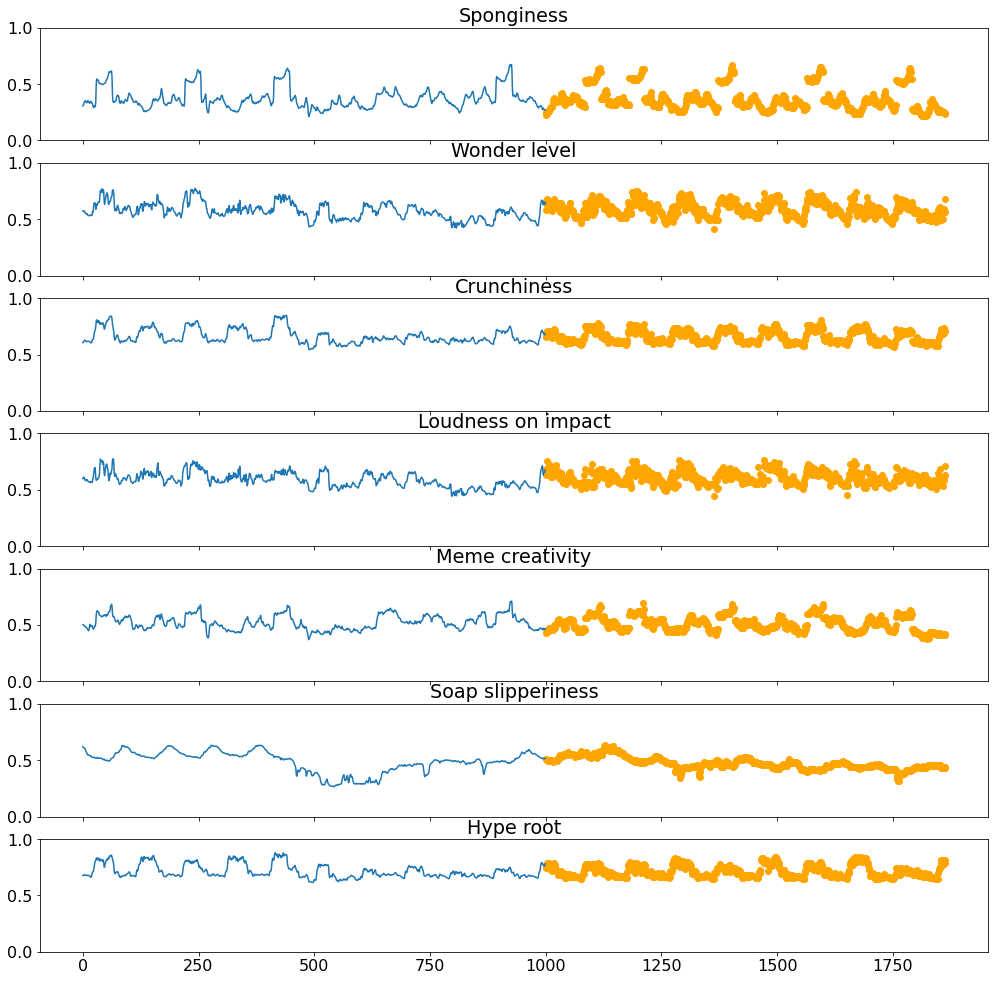

In [ ]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 8
epochs = 150

In [ ]:
print(input_shape, output_shape)

(1000, 7) (864, 7)


(None, 1000, 256)
(None, 1000, 256)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 1000, 7)]         0         
                                                                 
 bidirectional (Bidirectiona  (None, 1000, 256)        139264    
 l)                                                              
                                                                 
 seq_self_attention (SeqSelf  (None, 1000, 256)        16449     
 Attention)                                                      
                                                                 
 global_average_pooling1d (G  (None, 256)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6048)              1554336   
                         

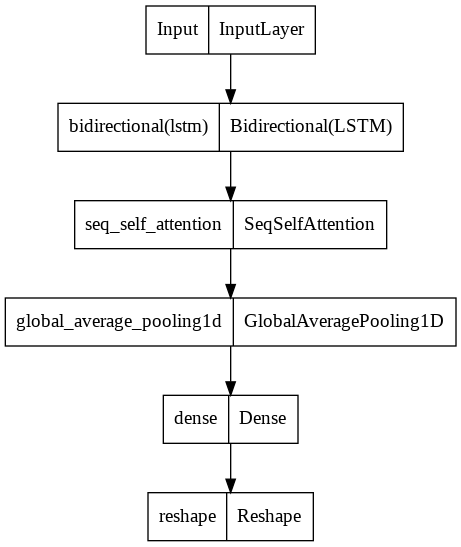

In [ ]:
model = build_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

# Training and testing

In [ ]:
# Create folders and callbacks and fit
cbs = create_folders_and_callbacks(model_name = title) #the model name will generate the folder of this single experiment

# restore checkpoints:
#model.load_weights('/gdrive/MyDrive/Documenti/Università/Magistrale/SecondoAnno/PrimoSemestre/AN2DL/Challenge2/Check/+'title'+_datetime/ckpts/cp.ckpt') #for this, I've looked at: https://www.tensorflow.org/tutorials/keras/save_and_load
#In this way, the training will restart from that specific checkpoint: clearly, Epoch number will restart from zero, but that's not a problem, it's restarting from the weights computed at ckpt

# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = cbs
).history

Epoch 1/150
699/699 [==============================] - ETA: 0s - loss: 0.1113 - mae: 0.2414 - rmse: 0.3336

699/699 [==============================] - 121s 169ms/step - loss: 0.1113 - mae: 0.2414 - rmse: 0.3336 - val_loss: 0.0889 - val_mae: 0.2067 - val_rmse: 0.2982 - lr: 1.0000e-04
Epoch 2/150
699/699 [==============================] - ETA: 0s - loss: 0.0817 - mae: 0.1912 - rmse: 0.2858

699/699 [==============================] - 116s 166ms/step - loss: 0.0817 - mae: 0.1912 - rmse: 0.2858 - val_loss: 0.0740 - val_mae: 0.1806 - val_rmse: 0.2721 - lr: 1.0000e-04
Epoch 3/150
699/699 [==============================] - ETA: 0s - loss: 0.0712 - mae: 0.1733 - rmse: 0.2669

699/699 [==============================] - 116s 166ms/step - loss: 0.0712 - mae: 0.1733 - rmse: 0.2669 - val_loss: 0.0698 - val_mae: 0.1753 - val_rmse: 0.2642 - lr: 1.0000e-04
Epoch 4/150
699/699 [==============================] - ETA: 0s - loss: 0.0643 - mae: 0.1623 - rmse: 0.2536

699/699 [==============================] - 117s 167ms/step - loss: 0.0643 - mae: 0.1623 - rmse: 0.2536 - val_loss: 0.0635 - val_mae: 0.1659 - val_rmse: 0.2519 - lr: 1.0000e-04
Epoch 5/150
699/699 [==============================] - ETA: 0s - loss: 0.0593 - mae: 0.1537 - rmse: 0.2436

699/699 [==============================] - 116s 166ms/step - loss: 0.0593 - mae: 0.1537 - rmse: 0.2436 - val_loss: 0.0587 - val_mae: 0.1592 - val_rmse: 0.2423 - lr: 1.0000e-04
Epoch 6/150
699/699 [==============================] - ETA: 0s - loss: 0.0550 - mae: 0.1467 - rmse: 0.2346

699/699 [==============================] - 117s 167ms/step - loss: 0.0550 - mae: 0.1467 - rmse: 0.2346 - val_loss: 0.0566 - val_mae: 0.1541 - val_rmse: 0.2379 - lr: 1.0000e-04
Epoch 7/150
699/699 [==============================] - ETA: 0s - loss: 0.0526 - mae: 0.1422 - rmse: 0.2293

699/699 [==============================] - 117s 167ms/step - loss: 0.0526 - mae: 0.1422 - rmse: 0.2293 - val_loss: 0.0547 - val_mae: 0.1512 - val_rmse: 0.2339 - lr: 1.0000e-04
Epoch 8/150
699/699 [==============================] - ETA: 0s - loss: 0.0508 - mae: 0.1404 - rmse: 0.2254

699/699 [==============================] - 117s 167ms/step - loss: 0.0508 - mae: 0.1404 - rmse: 0.2254 - val_loss: 0.0521 - val_mae: 0.1453 - val_rmse: 0.2282 - lr: 1.0000e-04
Epoch 9/150
699/699 [==============================] - ETA: 0s - loss: 0.0481 - mae: 0.1360 - rmse: 0.2194

699/699 [==============================] - 116s 166ms/step - loss: 0.0481 - mae: 0.1360 - rmse: 0.2194 - val_loss: 0.0516 - val_mae: 0.1450 - val_rmse: 0.2270 - lr: 1.0000e-04
Epoch 10/150
699/699 [==============================] - ETA: 0s - loss: 0.0473 - mae: 0.1343 - rmse: 0.2175

699/699 [==============================] - 117s 167ms/step - loss: 0.0473 - mae: 0.1343 - rmse: 0.2175 - val_loss: 0.0501 - val_mae: 0.1459 - val_rmse: 0.2239 - lr: 1.0000e-04
Epoch 11/150
699/699 [==============================] - ETA: 0s - loss: 0.0455 - mae: 0.1306 - rmse: 0.2134

699/699 [==============================] - 117s 167ms/step - loss: 0.0455 - mae: 0.1306 - rmse: 0.2134 - val_loss: 0.0491 - val_mae: 0.1433 - val_rmse: 0.2215 - lr: 1.0000e-04
Epoch 12/150
699/699 [==============================] - ETA: 0s - loss: 0.0445 - mae: 0.1289 - rmse: 0.2109

699/699 [==============================] - 117s 167ms/step - loss: 0.0445 - mae: 0.1289 - rmse: 0.2109 - val_loss: 0.0480 - val_mae: 0.1425 - val_rmse: 0.2191 - lr: 1.0000e-04
Epoch 13/150
699/699 [==============================] - ETA: 0s - loss: 0.0420 - mae: 0.1267 - rmse: 0.2050

699/699 [==============================] - 116s 167ms/step - loss: 0.0420 - mae: 0.1267 - rmse: 0.2050 - val_loss: 0.0426 - val_mae: 0.1329 - val_rmse: 0.2065 - lr: 1.0000e-04
Epoch 14/150
699/699 [==============================] - ETA: 0s - loss: 0.0372 - mae: 0.1189 - rmse: 0.1930

699/699 [==============================] - 116s 166ms/step - loss: 0.0372 - mae: 0.1189 - rmse: 0.1930 - val_loss: 0.0413 - val_mae: 0.1294 - val_rmse: 0.2032 - lr: 1.0000e-04
Epoch 15/150
699/699 [==============================] - ETA: 0s - loss: 0.0358 - mae: 0.1169 - rmse: 0.1893

699/699 [==============================] - 117s 167ms/step - loss: 0.0358 - mae: 0.1169 - rmse: 0.1893 - val_loss: 0.0391 - val_mae: 0.1288 - val_rmse: 0.1978 - lr: 1.0000e-04
Epoch 16/150
699/699 [==============================] - ETA: 0s - loss: 0.0327 - mae: 0.1121 - rmse: 0.1808

699/699 [==============================] - 117s 168ms/step - loss: 0.0327 - mae: 0.1121 - rmse: 0.1808 - val_loss: 0.0366 - val_mae: 0.1254 - val_rmse: 0.1914 - lr: 1.0000e-04
Epoch 17/150
699/699 [==============================] - ETA: 0s - loss: 0.0309 - mae: 0.1084 - rmse: 0.1758

699/699 [==============================] - 118s 169ms/step - loss: 0.0309 - mae: 0.1084 - rmse: 0.1758 - val_loss: 0.0361 - val_mae: 0.1226 - val_rmse: 0.1901 - lr: 1.0000e-04
Epoch 18/150
699/699 [==============================] - ETA: 0s - loss: 0.0306 - mae: 0.1082 - rmse: 0.1749

699/699 [==============================] - 117s 168ms/step - loss: 0.0306 - mae: 0.1082 - rmse: 0.1749 - val_loss: 0.0357 - val_mae: 0.1223 - val_rmse: 0.1889 - lr: 1.0000e-04
Epoch 19/150
699/699 [==============================] - ETA: 0s - loss: 0.0299 - mae: 0.1070 - rmse: 0.1730

699/699 [==============================] - 116s 166ms/step - loss: 0.0299 - mae: 0.1070 - rmse: 0.1730 - val_loss: 0.0361 - val_mae: 0.1236 - val_rmse: 0.1899 - lr: 1.0000e-04
Epoch 20/150
699/699 [==============================] - ETA: 0s - loss: 0.0292 - mae: 0.1059 - rmse: 0.1710

699/699 [==============================] - 117s 167ms/step - loss: 0.0292 - mae: 0.1059 - rmse: 0.1710 - val_loss: 0.0350 - val_mae: 0.1224 - val_rmse: 0.1872 - lr: 1.0000e-04
Epoch 21/150
699/699 [==============================] - ETA: 0s - loss: 0.0284 - mae: 0.1048 - rmse: 0.1685

699/699 [==============================] - 117s 167ms/step - loss: 0.0284 - mae: 0.1048 - rmse: 0.1685 - val_loss: 0.0345 - val_mae: 0.1208 - val_rmse: 0.1856 - lr: 1.0000e-04
Epoch 22/150
699/699 [==============================] - ETA: 0s - loss: 0.0264 - mae: 0.1006 - rmse: 0.1625

699/699 [==============================] - 116s 166ms/step - loss: 0.0264 - mae: 0.1006 - rmse: 0.1625 - val_loss: 0.0329 - val_mae: 0.1171 - val_rmse: 0.1814 - lr: 1.0000e-04
Epoch 23/150
699/699 [==============================] - ETA: 0s - loss: 0.0257 - mae: 0.0991 - rmse: 0.1603

699/699 [==============================] - 116s 166ms/step - loss: 0.0257 - mae: 0.0991 - rmse: 0.1603 - val_loss: 0.0321 - val_mae: 0.1176 - val_rmse: 0.1793 - lr: 1.0000e-04
Epoch 24/150
699/699 [==============================] - ETA: 0s - loss: 0.0251 - mae: 0.0982 - rmse: 0.1584

699/699 [==============================] - 116s 166ms/step - loss: 0.0251 - mae: 0.0982 - rmse: 0.1584 - val_loss: 0.0319 - val_mae: 0.1175 - val_rmse: 0.1785 - lr: 1.0000e-04
Epoch 25/150
699/699 [==============================] - ETA: 0s - loss: 0.0247 - mae: 0.0971 - rmse: 0.1573

699/699 [==============================] - 117s 167ms/step - loss: 0.0247 - mae: 0.0971 - rmse: 0.1573 - val_loss: 0.0313 - val_mae: 0.1170 - val_rmse: 0.1770 - lr: 1.0000e-04
Epoch 26/150
699/699 [==============================] - ETA: 0s - loss: 0.0254 - mae: 0.1004 - rmse: 0.1595

699/699 [==============================] - 117s 168ms/step - loss: 0.0254 - mae: 0.1004 - rmse: 0.1595 - val_loss: 0.0309 - val_mae: 0.1125 - val_rmse: 0.1759 - lr: 1.0000e-04
Epoch 27/150
699/699 [==============================] - ETA: 0s - loss: 0.0254 - mae: 0.1018 - rmse: 0.1594

699/699 [==============================] - 117s 167ms/step - loss: 0.0254 - mae: 0.1018 - rmse: 0.1594 - val_loss: 0.0298 - val_mae: 0.1120 - val_rmse: 0.1727 - lr: 1.0000e-04
Epoch 28/150
699/699 [==============================] - ETA: 0s - loss: 0.0242 - mae: 0.0977 - rmse: 0.1556

699/699 [==============================] - 116s 166ms/step - loss: 0.0242 - mae: 0.0977 - rmse: 0.1556 - val_loss: 0.0289 - val_mae: 0.1106 - val_rmse: 0.1699 - lr: 1.0000e-04
Epoch 29/150
699/699 [==============================] - ETA: 0s - loss: 0.0238 - mae: 0.0970 - rmse: 0.1544

699/699 [==============================] - 117s 167ms/step - loss: 0.0238 - mae: 0.0970 - rmse: 0.1544 - val_loss: 0.0287 - val_mae: 0.1103 - val_rmse: 0.1693 - lr: 1.0000e-04
Epoch 30/150
699/699 [==============================] - ETA: 0s - loss: 0.0234 - mae: 0.0956 - rmse: 0.1530

699/699 [==============================] - 117s 168ms/step - loss: 0.0234 - mae: 0.0956 - rmse: 0.1530 - val_loss: 0.0285 - val_mae: 0.1106 - val_rmse: 0.1688 - lr: 1.0000e-04
Epoch 31/150
699/699 [==============================] - ETA: 0s - loss: 0.0226 - mae: 0.0941 - rmse: 0.1502

699/699 [==============================] - 117s 167ms/step - loss: 0.0226 - mae: 0.0941 - rmse: 0.1502 - val_loss: 0.0275 - val_mae: 0.1080 - val_rmse: 0.1658 - lr: 1.0000e-04
Epoch 32/150
699/699 [==============================] - ETA: 0s - loss: 0.0219 - mae: 0.0919 - rmse: 0.1480

699/699 [==============================] - 117s 167ms/step - loss: 0.0219 - mae: 0.0919 - rmse: 0.1480 - val_loss: 0.0272 - val_mae: 0.1093 - val_rmse: 0.1648 - lr: 1.0000e-04
Epoch 33/150
699/699 [==============================] - ETA: 0s - loss: 0.0221 - mae: 0.0927 - rmse: 0.1485

699/699 [==============================] - 117s 168ms/step - loss: 0.0221 - mae: 0.0927 - rmse: 0.1485 - val_loss: 0.0270 - val_mae: 0.1096 - val_rmse: 0.1644 - lr: 1.0000e-04
Epoch 34/150
699/699 [==============================] - ETA: 0s - loss: 0.0219 - mae: 0.0936 - rmse: 0.1481

699/699 [==============================] - 117s 167ms/step - loss: 0.0219 - mae: 0.0936 - rmse: 0.1481 - val_loss: 0.0270 - val_mae: 0.1107 - val_rmse: 0.1645 - lr: 1.0000e-04
Epoch 35/150
699/699 [==============================] - ETA: 0s - loss: 0.0211 - mae: 0.0912 - rmse: 0.1453

699/699 [==============================] - 117s 167ms/step - loss: 0.0211 - mae: 0.0912 - rmse: 0.1453 - val_loss: 0.0263 - val_mae: 0.1080 - val_rmse: 0.1621 - lr: 1.0000e-04
Epoch 36/150
699/699 [==============================] - ETA: 0s - loss: 0.0204 - mae: 0.0891 - rmse: 0.1429

699/699 [==============================] - 116s 167ms/step - loss: 0.0204 - mae: 0.0891 - rmse: 0.1429 - val_loss: 0.0255 - val_mae: 0.1062 - val_rmse: 0.1597 - lr: 1.0000e-04
Epoch 37/150
699/699 [==============================] - ETA: 0s - loss: 0.0199 - mae: 0.0880 - rmse: 0.1412

699/699 [==============================] - 116s 166ms/step - loss: 0.0199 - mae: 0.0880 - rmse: 0.1412 - val_loss: 0.0252 - val_mae: 0.1046 - val_rmse: 0.1589 - lr: 1.0000e-04
Epoch 38/150
699/699 [==============================] - ETA: 0s - loss: 0.0198 - mae: 0.0878 - rmse: 0.1408

699/699 [==============================] - 117s 167ms/step - loss: 0.0198 - mae: 0.0878 - rmse: 0.1408 - val_loss: 0.0254 - val_mae: 0.1054 - val_rmse: 0.1593 - lr: 1.0000e-04
Epoch 39/150
699/699 [==============================] - ETA: 0s - loss: 0.0193 - mae: 0.0863 - rmse: 0.1388

699/699 [==============================] - 117s 167ms/step - loss: 0.0193 - mae: 0.0863 - rmse: 0.1388 - val_loss: 0.0246 - val_mae: 0.1038 - val_rmse: 0.1570 - lr: 1.0000e-04
Epoch 40/150
699/699 [==============================] - ETA: 0s - loss: 0.0189 - mae: 0.0859 - rmse: 0.1376

699/699 [==============================] - 117s 167ms/step - loss: 0.0189 - mae: 0.0859 - rmse: 0.1376 - val_loss: 0.0234 - val_mae: 0.1018 - val_rmse: 0.1529 - lr: 1.0000e-04
Epoch 41/150
699/699 [==============================] - ETA: 0s - loss: 0.0183 - mae: 0.0846 - rmse: 0.1353

699/699 [==============================] - 117s 167ms/step - loss: 0.0183 - mae: 0.0846 - rmse: 0.1353 - val_loss: 0.0235 - val_mae: 0.1031 - val_rmse: 0.1533 - lr: 1.0000e-04
Epoch 42/150
699/699 [==============================] - ETA: 0s - loss: 0.0199 - mae: 0.0932 - rmse: 0.1409

699/699 [==============================] - 117s 167ms/step - loss: 0.0199 - mae: 0.0932 - rmse: 0.1409 - val_loss: 0.0266 - val_mae: 0.1171 - val_rmse: 0.1631 - lr: 1.0000e-04
Epoch 43/150
699/699 [==============================] - ETA: 0s - loss: 0.0186 - mae: 0.0912 - rmse: 0.1363

699/699 [==============================] - 117s 168ms/step - loss: 0.0186 - mae: 0.0912 - rmse: 0.1363 - val_loss: 0.0237 - val_mae: 0.1010 - val_rmse: 0.1540 - lr: 1.0000e-04
Epoch 44/150
699/699 [==============================] - ETA: 0s - loss: 0.0179 - mae: 0.0885 - rmse: 0.1336

699/699 [==============================] - 117s 167ms/step - loss: 0.0179 - mae: 0.0885 - rmse: 0.1336 - val_loss: 0.0236 - val_mae: 0.1031 - val_rmse: 0.1536 - lr: 1.0000e-04
Epoch 45/150
699/699 [==============================] - ETA: 0s - loss: 0.0172 - mae: 0.0875 - rmse: 0.1313

699/699 [==============================] - 117s 168ms/step - loss: 0.0172 - mae: 0.0875 - rmse: 0.1313 - val_loss: 0.0228 - val_mae: 0.1026 - val_rmse: 0.1509 - lr: 1.0000e-04
Epoch 46/150
699/699 [==============================] - ETA: 0s - loss: 0.0157 - mae: 0.0839 - rmse: 0.1252

699/699 [==============================] - 117s 168ms/step - loss: 0.0157 - mae: 0.0839 - rmse: 0.1252 - val_loss: 0.0217 - val_mae: 0.0997 - val_rmse: 0.1472 - lr: 1.0000e-04
Epoch 47/150
699/699 [==============================] - ETA: 0s - loss: 0.0147 - mae: 0.0813 - rmse: 0.1211

699/699 [==============================] - 117s 168ms/step - loss: 0.0147 - mae: 0.0813 - rmse: 0.1211 - val_loss: 0.0213 - val_mae: 0.1008 - val_rmse: 0.1460 - lr: 1.0000e-04
Epoch 48/150
699/699 [==============================] - ETA: 0s - loss: 0.0151 - mae: 0.0831 - rmse: 0.1230

699/699 [==============================] - 117s 168ms/step - loss: 0.0151 - mae: 0.0831 - rmse: 0.1230 - val_loss: 0.0202 - val_mae: 0.0985 - val_rmse: 0.1421 - lr: 1.0000e-04
Epoch 49/150
699/699 [==============================] - ETA: 0s - loss: 0.0142 - mae: 0.0802 - rmse: 0.1190

699/699 [==============================] - 117s 168ms/step - loss: 0.0142 - mae: 0.0802 - rmse: 0.1190 - val_loss: 0.0207 - val_mae: 0.0992 - val_rmse: 0.1437 - lr: 1.0000e-04
Epoch 50/150
699/699 [==============================] - ETA: 0s - loss: 0.0138 - mae: 0.0789 - rmse: 0.1175

699/699 [==============================] - 118s 168ms/step - loss: 0.0138 - mae: 0.0789 - rmse: 0.1175 - val_loss: 0.0205 - val_mae: 0.0992 - val_rmse: 0.1433 - lr: 1.0000e-04
Epoch 51/150
699/699 [==============================] - ETA: 0s - loss: 0.0136 - mae: 0.0780 - rmse: 0.1164

699/699 [==============================] - 117s 168ms/step - loss: 0.0136 - mae: 0.0780 - rmse: 0.1164 - val_loss: 0.0203 - val_mae: 0.0977 - val_rmse: 0.1425 - lr: 1.0000e-04
Epoch 52/150
699/699 [==============================] - ETA: 0s - loss: 0.0137 - mae: 0.0789 - rmse: 0.1173

699/699 [==============================] - 117s 168ms/step - loss: 0.0137 - mae: 0.0789 - rmse: 0.1173 - val_loss: 0.0195 - val_mae: 0.0953 - val_rmse: 0.1396 - lr: 1.0000e-04
Epoch 53/150
699/699 [==============================] - ETA: 0s - loss: 0.0129 - mae: 0.0763 - rmse: 0.1137

699/699 [==============================] - 117s 167ms/step - loss: 0.0129 - mae: 0.0763 - rmse: 0.1137 - val_loss: 0.0189 - val_mae: 0.0944 - val_rmse: 0.1375 - lr: 1.0000e-04
Epoch 54/150
699/699 [==============================] - ETA: 0s - loss: 0.0131 - mae: 0.0772 - rmse: 0.1143

699/699 [==============================] - 118s 168ms/step - loss: 0.0131 - mae: 0.0772 - rmse: 0.1143 - val_loss: 0.0183 - val_mae: 0.0931 - val_rmse: 0.1351 - lr: 1.0000e-04
Epoch 55/150
699/699 [==============================] - ETA: 0s - loss: 0.0123 - mae: 0.0743 - rmse: 0.1110

699/699 [==============================] - 117s 167ms/step - loss: 0.0123 - mae: 0.0743 - rmse: 0.1110 - val_loss: 0.0178 - val_mae: 0.0925 - val_rmse: 0.1332 - lr: 1.0000e-04
Epoch 56/150
699/699 [==============================] - ETA: 0s - loss: 0.0124 - mae: 0.0747 - rmse: 0.1116

699/699 [==============================] - 117s 168ms/step - loss: 0.0124 - mae: 0.0747 - rmse: 0.1116 - val_loss: 0.0177 - val_mae: 0.0926 - val_rmse: 0.1332 - lr: 1.0000e-04
Epoch 57/150
699/699 [==============================] - ETA: 0s - loss: 0.0128 - mae: 0.0759 - rmse: 0.1129

699/699 [==============================] - 117s 168ms/step - loss: 0.0128 - mae: 0.0759 - rmse: 0.1129 - val_loss: 0.0183 - val_mae: 0.0933 - val_rmse: 0.1354 - lr: 1.0000e-04
Epoch 58/150
699/699 [==============================] - ETA: 0s - loss: 0.0119 - mae: 0.0730 - rmse: 0.1093

699/699 [==============================] - 117s 168ms/step - loss: 0.0119 - mae: 0.0730 - rmse: 0.1093 - val_loss: 0.0176 - val_mae: 0.0922 - val_rmse: 0.1325 - lr: 1.0000e-04
Epoch 59/150
699/699 [==============================] - ETA: 0s - loss: 0.0120 - mae: 0.0731 - rmse: 0.1096

699/699 [==============================] - 117s 167ms/step - loss: 0.0120 - mae: 0.0731 - rmse: 0.1096 - val_loss: 0.0174 - val_mae: 0.0911 - val_rmse: 0.1318 - lr: 1.0000e-04
Epoch 60/150
699/699 [==============================] - ETA: 0s - loss: 0.0118 - mae: 0.0725 - rmse: 0.1086

699/699 [==============================] - 117s 168ms/step - loss: 0.0118 - mae: 0.0725 - rmse: 0.1086 - val_loss: 0.0178 - val_mae: 0.0925 - val_rmse: 0.1334 - lr: 1.0000e-04
Epoch 61/150
699/699 [==============================] - ETA: 0s - loss: 0.0114 - mae: 0.0711 - rmse: 0.1070

699/699 [==============================] - 117s 168ms/step - loss: 0.0114 - mae: 0.0711 - rmse: 0.1070 - val_loss: 0.0172 - val_mae: 0.0910 - val_rmse: 0.1311 - lr: 1.0000e-04
Epoch 62/150
699/699 [==============================] - ETA: 0s - loss: 0.0121 - mae: 0.0735 - rmse: 0.1099

699/699 [==============================] - 118s 168ms/step - loss: 0.0121 - mae: 0.0735 - rmse: 0.1099 - val_loss: 0.0173 - val_mae: 0.0900 - val_rmse: 0.1315 - lr: 1.0000e-04
Epoch 63/150
699/699 [==============================] - ETA: 0s - loss: 0.0127 - mae: 0.0756 - rmse: 0.1126

699/699 [==============================] - 117s 168ms/step - loss: 0.0127 - mae: 0.0756 - rmse: 0.1126 - val_loss: 0.0169 - val_mae: 0.0899 - val_rmse: 0.1302 - lr: 1.0000e-04
Epoch 64/150
699/699 [==============================] - ETA: 0s - loss: 0.0122 - mae: 0.0741 - rmse: 0.1105

699/699 [==============================] - 118s 168ms/step - loss: 0.0122 - mae: 0.0741 - rmse: 0.1105 - val_loss: 0.0173 - val_mae: 0.0916 - val_rmse: 0.1316 - lr: 1.0000e-04
Epoch 65/150
699/699 [==============================] - ETA: 0s - loss: 0.0119 - mae: 0.0732 - rmse: 0.1092

699/699 [==============================] - 117s 167ms/step - loss: 0.0119 - mae: 0.0732 - rmse: 0.1092 - val_loss: 0.0171 - val_mae: 0.0911 - val_rmse: 0.1309 - lr: 1.0000e-04
Epoch 66/150
699/699 [==============================] - ETA: 0s - loss: 0.0121 - mae: 0.0735 - rmse: 0.1099

699/699 [==============================] - 117s 167ms/step - loss: 0.0121 - mae: 0.0735 - rmse: 0.1099 - val_loss: 0.0192 - val_mae: 0.0965 - val_rmse: 0.1385 - lr: 1.0000e-04
Epoch 67/150
699/699 [==============================] - ETA: 0s - loss: 0.0115 - mae: 0.0713 - rmse: 0.1071

699/699 [==============================] - 118s 168ms/step - loss: 0.0115 - mae: 0.0713 - rmse: 0.1071 - val_loss: 0.0169 - val_mae: 0.0917 - val_rmse: 0.1300 - lr: 1.0000e-04
Epoch 68/150
699/699 [==============================] - ETA: 0s - loss: 0.0267 - mae: 0.1030 - rmse: 0.1635

699/699 [==============================] - 118s 169ms/step - loss: 0.0267 - mae: 0.1030 - rmse: 0.1635 - val_loss: 0.0333 - val_mae: 0.1162 - val_rmse: 0.1826 - lr: 1.0000e-04
Epoch 69/150
699/699 [==============================] - ETA: 0s - loss: 0.0290 - mae: 0.1046 - rmse: 0.1704

699/699 [==============================] - 117s 168ms/step - loss: 0.0290 - mae: 0.1046 - rmse: 0.1704 - val_loss: 0.0317 - val_mae: 0.1138 - val_rmse: 0.1781 - lr: 1.0000e-04
Epoch 70/150
699/699 [==============================] - ETA: 0s - loss: 0.0270 - mae: 0.0997 - rmse: 0.1644

699/699 [==============================] - 118s 168ms/step - loss: 0.0270 - mae: 0.0997 - rmse: 0.1644 - val_loss: 0.0315 - val_mae: 0.1135 - val_rmse: 0.1775 - lr: 1.0000e-04
Epoch 71/150
699/699 [==============================] - ETA: 0s - loss: 0.0269 - mae: 0.1016 - rmse: 0.1640

699/699 [==============================] - 117s 168ms/step - loss: 0.0269 - mae: 0.1016 - rmse: 0.1640 - val_loss: 0.0297 - val_mae: 0.1098 - val_rmse: 0.1724 - lr: 1.0000e-04
Epoch 72/150
699/699 [==============================] - ETA: 0s - loss: 0.0252 - mae: 0.0975 - rmse: 0.1587

699/699 [==============================] - 118s 168ms/step - loss: 0.0252 - mae: 0.0975 - rmse: 0.1587 - val_loss: 0.0294 - val_mae: 0.1095 - val_rmse: 0.1716 - lr: 1.0000e-04
Epoch 73/150
699/699 [==============================] - ETA: 0s - loss: 0.0246 - mae: 0.0962 - rmse: 0.1569

699/699 [==============================] - 118s 169ms/step - loss: 0.0246 - mae: 0.0962 - rmse: 0.1569 - val_loss: 0.0296 - val_mae: 0.1096 - val_rmse: 0.1719 - lr: 5.0000e-05
Epoch 74/150
699/699 [==============================] - ETA: 0s - loss: 0.0247 - mae: 0.0973 - rmse: 0.1570

699/699 [==============================] - 118s 168ms/step - loss: 0.0247 - mae: 0.0973 - rmse: 0.1570 - val_loss: 0.0287 - val_mae: 0.1085 - val_rmse: 0.1694 - lr: 5.0000e-05
Epoch 75/150
699/699 [==============================] - ETA: 0s - loss: 0.0241 - mae: 0.0955 - rmse: 0.1552

699/699 [==============================] - 118s 168ms/step - loss: 0.0241 - mae: 0.0955 - rmse: 0.1552 - val_loss: 0.0285 - val_mae: 0.1082 - val_rmse: 0.1687 - lr: 5.0000e-05
Epoch 76/150
699/699 [==============================] - ETA: 0s - loss: 0.0234 - mae: 0.0945 - rmse: 0.1530

699/699 [==============================] - 118s 169ms/step - loss: 0.0234 - mae: 0.0945 - rmse: 0.1530 - val_loss: 0.0281 - val_mae: 0.1079 - val_rmse: 0.1677 - lr: 5.0000e-05
Epoch 77/150
699/699 [==============================] - ETA: 0s - loss: 0.0231 - mae: 0.0945 - rmse: 0.1518

699/699 [==============================] - 117s 168ms/step - loss: 0.0231 - mae: 0.0945 - rmse: 0.1518 - val_loss: 0.0276 - val_mae: 0.1075 - val_rmse: 0.1661 - lr: 5.0000e-05
Epoch 78/150
699/699 [==============================] - ETA: 0s - loss: 0.0221 - mae: 0.0934 - rmse: 0.1487

699/699 [==============================] - 118s 168ms/step - loss: 0.0221 - mae: 0.0934 - rmse: 0.1487 - val_loss: 0.0267 - val_mae: 0.1045 - val_rmse: 0.1634 - lr: 2.5000e-05
Epoch 79/150
699/699 [==============================] - ETA: 0s - loss: 0.0188 - mae: 0.0917 - rmse: 0.1370

699/699 [==============================] - 118s 168ms/step - loss: 0.0188 - mae: 0.0917 - rmse: 0.1370 - val_loss: 0.0216 - val_mae: 0.0987 - val_rmse: 0.1468 - lr: 2.5000e-05
Epoch 80/150
699/699 [==============================] - ETA: 0s - loss: 0.0158 - mae: 0.0866 - rmse: 0.1259

699/699 [==============================] - 118s 168ms/step - loss: 0.0158 - mae: 0.0866 - rmse: 0.1259 - val_loss: 0.0209 - val_mae: 0.0975 - val_rmse: 0.1447 - lr: 2.5000e-05
Epoch 81/150
699/699 [==============================] - ETA: 0s - loss: 0.0153 - mae: 0.0853 - rmse: 0.1239

699/699 [==============================] - 117s 168ms/step - loss: 0.0153 - mae: 0.0853 - rmse: 0.1239 - val_loss: 0.0209 - val_mae: 0.0974 - val_rmse: 0.1444 - lr: 2.5000e-05
Epoch 82/150
699/699 [==============================] - ETA: 0s - loss: 0.0151 - mae: 0.0854 - rmse: 0.1231

699/699 [==============================] - 118s 169ms/step - loss: 0.0151 - mae: 0.0854 - rmse: 0.1231 - val_loss: 0.0203 - val_mae: 0.0959 - val_rmse: 0.1424 - lr: 2.5000e-05
Epoch 83/150
699/699 [==============================] - ETA: 0s - loss: 0.0146 - mae: 0.0839 - rmse: 0.1210

699/699 [==============================] - 118s 169ms/step - loss: 0.0146 - mae: 0.0839 - rmse: 0.1210 - val_loss: 0.0201 - val_mae: 0.0965 - val_rmse: 0.1419 - lr: 1.2500e-05
Epoch 84/150
699/699 [==============================] - ETA: 0s - loss: 0.0145 - mae: 0.0840 - rmse: 0.1204

699/699 [==============================] - 118s 169ms/step - loss: 0.0145 - mae: 0.0840 - rmse: 0.1204 - val_loss: 0.0198 - val_mae: 0.0957 - val_rmse: 0.1409 - lr: 1.2500e-05
Epoch 85/150
699/699 [==============================] - ETA: 0s - loss: 0.0151 - mae: 0.0861 - rmse: 0.1228

699/699 [==============================] - 118s 169ms/step - loss: 0.0151 - mae: 0.0861 - rmse: 0.1228 - val_loss: 0.0198 - val_mae: 0.0957 - val_rmse: 0.1407 - lr: 1.2500e-05
Epoch 86/150
699/699 [==============================] - ETA: 0s - loss: 0.0145 - mae: 0.0841 - rmse: 0.1205

699/699 [==============================] - 118s 168ms/step - loss: 0.0145 - mae: 0.0841 - rmse: 0.1205 - val_loss: 0.0196 - val_mae: 0.0953 - val_rmse: 0.1401 - lr: 1.2500e-05
Epoch 87/150
699/699 [==============================] - ETA: 0s - loss: 0.0141 - mae: 0.0827 - rmse: 0.1189

699/699 [==============================] - 118s 168ms/step - loss: 0.0141 - mae: 0.0827 - rmse: 0.1189 - val_loss: 0.0195 - val_mae: 0.0952 - val_rmse: 0.1398 - lr: 1.2500e-05
Epoch 88/150
699/699 [==============================] - ETA: 0s - loss: 0.0140 - mae: 0.0821 - rmse: 0.1181

699/699 [==============================] - 118s 168ms/step - loss: 0.0140 - mae: 0.0821 - rmse: 0.1181 - val_loss: 0.0195 - val_mae: 0.0953 - val_rmse: 0.1395 - lr: 1.0000e-05
Epoch 89/150
699/699 [==============================] - ETA: 0s - loss: 0.0139 - mae: 0.0820 - rmse: 0.1178

699/699 [==============================] - 117s 167ms/step - loss: 0.0139 - mae: 0.0820 - rmse: 0.1178 - val_loss: 0.0195 - val_mae: 0.0952 - val_rmse: 0.1396 - lr: 1.0000e-05
Epoch 90/150
699/699 [==============================] - ETA: 0s - loss: 0.0138 - mae: 0.0816 - rmse: 0.1173

699/699 [==============================] - 116s 166ms/step - loss: 0.0138 - mae: 0.0816 - rmse: 0.1173 - val_loss: 0.0193 - val_mae: 0.0949 - val_rmse: 0.1387 - lr: 1.0000e-05
Epoch 91/150
699/699 [==============================] - ETA: 0s - loss: 0.0135 - mae: 0.0811 - rmse: 0.1160

699/699 [==============================] - 117s 167ms/step - loss: 0.0135 - mae: 0.0811 - rmse: 0.1160 - val_loss: 0.0187 - val_mae: 0.0943 - val_rmse: 0.1367 - lr: 1.0000e-05
Epoch 92/150
699/699 [==============================] - ETA: 0s - loss: 0.0130 - mae: 0.0803 - rmse: 0.1140

699/699 [==============================] - 116s 166ms/step - loss: 0.0130 - mae: 0.0803 - rmse: 0.1140 - val_loss: 0.0184 - val_mae: 0.0938 - val_rmse: 0.1358 - lr: 1.0000e-05
Epoch 93/150
699/699 [==============================] - ETA: 0s - loss: 0.0129 - mae: 0.0805 - rmse: 0.1134

699/699 [==============================] - 117s 167ms/step - loss: 0.0129 - mae: 0.0805 - rmse: 0.1134 - val_loss: 0.0183 - val_mae: 0.0932 - val_rmse: 0.1354 - lr: 1.0000e-05
Epoch 94/150
699/699 [==============================] - ETA: 0s - loss: 0.0127 - mae: 0.0803 - rmse: 0.1127

699/699 [==============================] - 117s 167ms/step - loss: 0.0127 - mae: 0.0803 - rmse: 0.1127 - val_loss: 0.0181 - val_mae: 0.0933 - val_rmse: 0.1344 - lr: 1.0000e-05
Epoch 95/150
699/699 [==============================] - ETA: 0s - loss: 0.0125 - mae: 0.0799 - rmse: 0.1118

699/699 [==============================] - 117s 167ms/step - loss: 0.0125 - mae: 0.0799 - rmse: 0.1118 - val_loss: 0.0180 - val_mae: 0.0934 - val_rmse: 0.1342 - lr: 1.0000e-05
Epoch 96/150
699/699 [==============================] - ETA: 0s - loss: 0.0124 - mae: 0.0796 - rmse: 0.1114

699/699 [==============================] - 117s 167ms/step - loss: 0.0124 - mae: 0.0796 - rmse: 0.1114 - val_loss: 0.0179 - val_mae: 0.0929 - val_rmse: 0.1338 - lr: 1.0000e-05
Epoch 97/150
699/699 [==============================] - ETA: 0s - loss: 0.0122 - mae: 0.0791 - rmse: 0.1106

699/699 [==============================] - 117s 167ms/step - loss: 0.0122 - mae: 0.0791 - rmse: 0.1106 - val_loss: 0.0178 - val_mae: 0.0931 - val_rmse: 0.1333 - lr: 1.0000e-05
Epoch 98/150
699/699 [==============================] - ETA: 0s - loss: 0.0121 - mae: 0.0788 - rmse: 0.1102

699/699 [==============================] - 117s 167ms/step - loss: 0.0121 - mae: 0.0788 - rmse: 0.1102 - val_loss: 0.0177 - val_mae: 0.0931 - val_rmse: 0.1329 - lr: 1.0000e-05
Epoch 99/150
699/699 [==============================] - ETA: 0s - loss: 0.0121 - mae: 0.0787 - rmse: 0.1099

699/699 [==============================] - 117s 167ms/step - loss: 0.0121 - mae: 0.0787 - rmse: 0.1099 - val_loss: 0.0177 - val_mae: 0.0924 - val_rmse: 0.1329 - lr: 1.0000e-05
Epoch 100/150
699/699 [==============================] - ETA: 0s - loss: 0.0121 - mae: 0.0785 - rmse: 0.1101

699/699 [==============================] - 116s 166ms/step - loss: 0.0121 - mae: 0.0785 - rmse: 0.1101 - val_loss: 0.0175 - val_mae: 0.0922 - val_rmse: 0.1324 - lr: 1.0000e-05
Epoch 101/150
699/699 [==============================] - ETA: 0s - loss: 0.0120 - mae: 0.0784 - rmse: 0.1097

699/699 [==============================] - 117s 168ms/step - loss: 0.0120 - mae: 0.0784 - rmse: 0.1097 - val_loss: 0.0174 - val_mae: 0.0922 - val_rmse: 0.1320 - lr: 1.0000e-05
Epoch 102/150
699/699 [==============================] - ETA: 0s - loss: 0.0120 - mae: 0.0783 - rmse: 0.1096

699/699 [==============================] - 117s 167ms/step - loss: 0.0120 - mae: 0.0783 - rmse: 0.1096 - val_loss: 0.0174 - val_mae: 0.0919 - val_rmse: 0.1319 - lr: 1.0000e-05
Epoch 103/150
699/699 [==============================] - ETA: 0s - loss: 0.0120 - mae: 0.0781 - rmse: 0.1093

699/699 [==============================] - 117s 167ms/step - loss: 0.0120 - mae: 0.0781 - rmse: 0.1093 - val_loss: 0.0173 - val_mae: 0.0919 - val_rmse: 0.1314 - lr: 1.0000e-05
Epoch 104/150
699/699 [==============================] - ETA: 0s - loss: 0.0119 - mae: 0.0779 - rmse: 0.1091

699/699 [==============================] - 118s 169ms/step - loss: 0.0119 - mae: 0.0779 - rmse: 0.1091 - val_loss: 0.0171 - val_mae: 0.0917 - val_rmse: 0.1309 - lr: 1.0000e-05
Epoch 105/150
699/699 [==============================] - ETA: 0s - loss: 0.0118 - mae: 0.0777 - rmse: 0.1087

699/699 [==============================] - 117s 167ms/step - loss: 0.0118 - mae: 0.0777 - rmse: 0.1087 - val_loss: 0.0171 - val_mae: 0.0916 - val_rmse: 0.1308 - lr: 1.0000e-05
Epoch 106/150
699/699 [==============================] - ETA: 0s - loss: 0.0118 - mae: 0.0776 - rmse: 0.1084

699/699 [==============================] - 117s 168ms/step - loss: 0.0118 - mae: 0.0776 - rmse: 0.1084 - val_loss: 0.0170 - val_mae: 0.0912 - val_rmse: 0.1304 - lr: 1.0000e-05
Epoch 107/150
699/699 [==============================] - ETA: 0s - loss: 0.0117 - mae: 0.0774 - rmse: 0.1082

699/699 [==============================] - 117s 167ms/step - loss: 0.0117 - mae: 0.0774 - rmse: 0.1082 - val_loss: 0.0169 - val_mae: 0.0910 - val_rmse: 0.1301 - lr: 1.0000e-05
Epoch 108/150
699/699 [==============================] - ETA: 0s - loss: 0.0117 - mae: 0.0772 - rmse: 0.1080

699/699 [==============================] - 116s 167ms/step - loss: 0.0117 - mae: 0.0772 - rmse: 0.1080 - val_loss: 0.0169 - val_mae: 0.0911 - val_rmse: 0.1299 - lr: 1.0000e-05
Epoch 109/150
699/699 [==============================] - ETA: 0s - loss: 0.0116 - mae: 0.0770 - rmse: 0.1076

699/699 [==============================] - 117s 167ms/step - loss: 0.0116 - mae: 0.0770 - rmse: 0.1076 - val_loss: 0.0168 - val_mae: 0.0908 - val_rmse: 0.1295 - lr: 1.0000e-05
Epoch 110/150
699/699 [==============================] - ETA: 0s - loss: 0.0115 - mae: 0.0768 - rmse: 0.1073

699/699 [==============================] - 117s 167ms/step - loss: 0.0115 - mae: 0.0768 - rmse: 0.1073 - val_loss: 0.0168 - val_mae: 0.0904 - val_rmse: 0.1296 - lr: 1.0000e-05
Epoch 111/150
699/699 [==============================] - ETA: 0s - loss: 0.0114 - mae: 0.0764 - rmse: 0.1068

699/699 [==============================] - 116s 167ms/step - loss: 0.0114 - mae: 0.0764 - rmse: 0.1068 - val_loss: 0.0166 - val_mae: 0.0906 - val_rmse: 0.1287 - lr: 1.0000e-05
Epoch 112/150
699/699 [==============================] - ETA: 0s - loss: 0.0113 - mae: 0.0761 - rmse: 0.1063

699/699 [==============================] - 117s 167ms/step - loss: 0.0113 - mae: 0.0761 - rmse: 0.1063 - val_loss: 0.0165 - val_mae: 0.0907 - val_rmse: 0.1285 - lr: 1.0000e-05
Epoch 113/150
699/699 [==============================] - ETA: 0s - loss: 0.0112 - mae: 0.0758 - rmse: 0.1059

699/699 [==============================] - 117s 168ms/step - loss: 0.0112 - mae: 0.0758 - rmse: 0.1059 - val_loss: 0.0164 - val_mae: 0.0895 - val_rmse: 0.1283 - lr: 1.0000e-05
Epoch 114/150
699/699 [==============================] - ETA: 0s - loss: 0.0111 - mae: 0.0754 - rmse: 0.1054

699/699 [==============================] - 117s 168ms/step - loss: 0.0111 - mae: 0.0754 - rmse: 0.1054 - val_loss: 0.0162 - val_mae: 0.0898 - val_rmse: 0.1273 - lr: 1.0000e-05
Epoch 115/150
699/699 [==============================] - ETA: 0s - loss: 0.0110 - mae: 0.0750 - rmse: 0.1049

699/699 [==============================] - 116s 166ms/step - loss: 0.0110 - mae: 0.0750 - rmse: 0.1049 - val_loss: 0.0161 - val_mae: 0.0894 - val_rmse: 0.1270 - lr: 1.0000e-05
Epoch 116/150
699/699 [==============================] - ETA: 0s - loss: 0.0109 - mae: 0.0746 - rmse: 0.1044

699/699 [==============================] - 116s 166ms/step - loss: 0.0109 - mae: 0.0746 - rmse: 0.1044 - val_loss: 0.0160 - val_mae: 0.0887 - val_rmse: 0.1266 - lr: 1.0000e-05
Epoch 117/150
699/699 [==============================] - ETA: 0s - loss: 0.0108 - mae: 0.0743 - rmse: 0.1038

699/699 [==============================] - 117s 167ms/step - loss: 0.0108 - mae: 0.0743 - rmse: 0.1038 - val_loss: 0.0158 - val_mae: 0.0882 - val_rmse: 0.1256 - lr: 1.0000e-05
Epoch 118/150
699/699 [==============================] - ETA: 0s - loss: 0.0107 - mae: 0.0740 - rmse: 0.1035

699/699 [==============================] - 116s 166ms/step - loss: 0.0107 - mae: 0.0740 - rmse: 0.1035 - val_loss: 0.0155 - val_mae: 0.0879 - val_rmse: 0.1247 - lr: 1.0000e-05
Epoch 119/150
699/699 [==============================] - ETA: 0s - loss: 0.0107 - mae: 0.0739 - rmse: 0.1034

699/699 [==============================] - 117s 167ms/step - loss: 0.0107 - mae: 0.0739 - rmse: 0.1034 - val_loss: 0.0156 - val_mae: 0.0877 - val_rmse: 0.1247 - lr: 1.0000e-05
Epoch 120/150
699/699 [==============================] - ETA: 0s - loss: 0.0106 - mae: 0.0736 - rmse: 0.1029

699/699 [==============================] - 117s 167ms/step - loss: 0.0106 - mae: 0.0736 - rmse: 0.1029 - val_loss: 0.0155 - val_mae: 0.0879 - val_rmse: 0.1244 - lr: 1.0000e-05
Epoch 121/150
699/699 [==============================] - ETA: 0s - loss: 0.0105 - mae: 0.0733 - rmse: 0.1025

699/699 [==============================] - 116s 167ms/step - loss: 0.0105 - mae: 0.0733 - rmse: 0.1025 - val_loss: 0.0154 - val_mae: 0.0877 - val_rmse: 0.1240 - lr: 1.0000e-05
Epoch 122/150
699/699 [==============================] - ETA: 0s - loss: 0.0104 - mae: 0.0732 - rmse: 0.1021

699/699 [==============================] - 117s 167ms/step - loss: 0.0104 - mae: 0.0732 - rmse: 0.1021 - val_loss: 0.0153 - val_mae: 0.0872 - val_rmse: 0.1237 - lr: 1.0000e-05
Epoch 123/150
699/699 [==============================] - ETA: 0s - loss: 0.0104 - mae: 0.0731 - rmse: 0.1022

699/699 [==============================] - 117s 168ms/step - loss: 0.0104 - mae: 0.0731 - rmse: 0.1022 - val_loss: 0.0153 - val_mae: 0.0872 - val_rmse: 0.1235 - lr: 1.0000e-05
Epoch 124/150
699/699 [==============================] - ETA: 0s - loss: 0.0104 - mae: 0.0730 - rmse: 0.1020

699/699 [==============================] - 117s 168ms/step - loss: 0.0104 - mae: 0.0730 - rmse: 0.1020 - val_loss: 0.0153 - val_mae: 0.0871 - val_rmse: 0.1235 - lr: 1.0000e-05
Epoch 125/150
699/699 [==============================] - ETA: 0s - loss: 0.0103 - mae: 0.0727 - rmse: 0.1017

699/699 [==============================] - 117s 168ms/step - loss: 0.0103 - mae: 0.0727 - rmse: 0.1017 - val_loss: 0.0150 - val_mae: 0.0866 - val_rmse: 0.1225 - lr: 1.0000e-05
Epoch 126/150
699/699 [==============================] - ETA: 0s - loss: 0.0103 - mae: 0.0726 - rmse: 0.1014

699/699 [==============================] - 117s 167ms/step - loss: 0.0103 - mae: 0.0726 - rmse: 0.1014 - val_loss: 0.0149 - val_mae: 0.0865 - val_rmse: 0.1222 - lr: 1.0000e-05
Epoch 127/150
699/699 [==============================] - ETA: 0s - loss: 0.0103 - mae: 0.0725 - rmse: 0.1013

699/699 [==============================] - 117s 167ms/step - loss: 0.0103 - mae: 0.0725 - rmse: 0.1013 - val_loss: 0.0150 - val_mae: 0.0865 - val_rmse: 0.1223 - lr: 1.0000e-05
Epoch 128/150
699/699 [==============================] - ETA: 0s - loss: 0.0102 - mae: 0.0723 - rmse: 0.1010

699/699 [==============================] - 118s 168ms/step - loss: 0.0102 - mae: 0.0723 - rmse: 0.1010 - val_loss: 0.0149 - val_mae: 0.0866 - val_rmse: 0.1222 - lr: 1.0000e-05
Epoch 129/150
699/699 [==============================] - ETA: 0s - loss: 0.0102 - mae: 0.0721 - rmse: 0.1008

699/699 [==============================] - 117s 168ms/step - loss: 0.0102 - mae: 0.0721 - rmse: 0.1008 - val_loss: 0.0147 - val_mae: 0.0863 - val_rmse: 0.1213 - lr: 1.0000e-05
Epoch 130/150
699/699 [==============================] - ETA: 0s - loss: 0.0101 - mae: 0.0720 - rmse: 0.1006

699/699 [==============================] - 117s 168ms/step - loss: 0.0101 - mae: 0.0720 - rmse: 0.1006 - val_loss: 0.0149 - val_mae: 0.0868 - val_rmse: 0.1221 - lr: 1.0000e-05
Epoch 131/150
699/699 [==============================] - ETA: 0s - loss: 0.0101 - mae: 0.0718 - rmse: 0.1004

699/699 [==============================] - 117s 167ms/step - loss: 0.0101 - mae: 0.0718 - rmse: 0.1004 - val_loss: 0.0150 - val_mae: 0.0870 - val_rmse: 0.1225 - lr: 1.0000e-05
Epoch 132/150
699/699 [==============================] - ETA: 0s - loss: 0.0100 - mae: 0.0715 - rmse: 0.1000

699/699 [==============================] - 117s 167ms/step - loss: 0.0100 - mae: 0.0715 - rmse: 0.1000 - val_loss: 0.0149 - val_mae: 0.0863 - val_rmse: 0.1221 - lr: 1.0000e-05
Epoch 133/150
699/699 [==============================] - ETA: 0s - loss: 0.0099 - mae: 0.0713 - rmse: 0.0997

699/699 [==============================] - 117s 167ms/step - loss: 0.0099 - mae: 0.0713 - rmse: 0.0997 - val_loss: 0.0149 - val_mae: 0.0867 - val_rmse: 0.1219 - lr: 1.0000e-05
Epoch 134/150
699/699 [==============================] - ETA: 0s - loss: 0.0099 - mae: 0.0712 - rmse: 0.0996

699/699 [==============================] - 117s 168ms/step - loss: 0.0099 - mae: 0.0712 - rmse: 0.0996 - val_loss: 0.0148 - val_mae: 0.0863 - val_rmse: 0.1218 - lr: 1.0000e-05
Epoch 135/150
699/699 [==============================] - ETA: 0s - loss: 0.0099 - mae: 0.0710 - rmse: 0.0993

699/699 [==============================] - 117s 168ms/step - loss: 0.0099 - mae: 0.0710 - rmse: 0.0993 - val_loss: 0.0147 - val_mae: 0.0863 - val_rmse: 0.1212 - lr: 1.0000e-05
Epoch 136/150
699/699 [==============================] - ETA: 0s - loss: 0.0099 - mae: 0.0710 - rmse: 0.0994

699/699 [==============================] - 117s 168ms/step - loss: 0.0099 - mae: 0.0710 - rmse: 0.0994 - val_loss: 0.0148 - val_mae: 0.0865 - val_rmse: 0.1215 - lr: 1.0000e-05
Epoch 137/150
699/699 [==============================] - ETA: 0s - loss: 0.0099 - mae: 0.0711 - rmse: 0.0994

699/699 [==============================] - 117s 168ms/step - loss: 0.0099 - mae: 0.0711 - rmse: 0.0994 - val_loss: 0.0146 - val_mae: 0.0860 - val_rmse: 0.1208 - lr: 1.0000e-05
Epoch 138/150
699/699 [==============================] - ETA: 0s - loss: 0.0098 - mae: 0.0710 - rmse: 0.0991

699/699 [==============================] - 117s 168ms/step - loss: 0.0098 - mae: 0.0710 - rmse: 0.0991 - val_loss: 0.0146 - val_mae: 0.0863 - val_rmse: 0.1210 - lr: 1.0000e-05
Epoch 139/150
699/699 [==============================] - ETA: 0s - loss: 0.0098 - mae: 0.0709 - rmse: 0.0990

699/699 [==============================] - 118s 168ms/step - loss: 0.0098 - mae: 0.0709 - rmse: 0.0990 - val_loss: 0.0145 - val_mae: 0.0858 - val_rmse: 0.1204 - lr: 1.0000e-05
Epoch 140/150
699/699 [==============================] - ETA: 0s - loss: 0.0098 - mae: 0.0707 - rmse: 0.0988

699/699 [==============================] - 117s 168ms/step - loss: 0.0098 - mae: 0.0707 - rmse: 0.0988 - val_loss: 0.0145 - val_mae: 0.0863 - val_rmse: 0.1206 - lr: 1.0000e-05
Epoch 141/150
699/699 [==============================] - ETA: 0s - loss: 0.0097 - mae: 0.0706 - rmse: 0.0987

699/699 [==============================] - 117s 167ms/step - loss: 0.0097 - mae: 0.0706 - rmse: 0.0987 - val_loss: 0.0148 - val_mae: 0.0869 - val_rmse: 0.1215 - lr: 1.0000e-05
Epoch 142/150
699/699 [==============================] - ETA: 0s - loss: 0.0097 - mae: 0.0706 - rmse: 0.0985

699/699 [==============================] - 117s 168ms/step - loss: 0.0097 - mae: 0.0706 - rmse: 0.0985 - val_loss: 0.0143 - val_mae: 0.0856 - val_rmse: 0.1197 - lr: 1.0000e-05
Epoch 143/150
699/699 [==============================] - ETA: 0s - loss: 0.0097 - mae: 0.0705 - rmse: 0.0985

699/699 [==============================] - 117s 167ms/step - loss: 0.0097 - mae: 0.0705 - rmse: 0.0985 - val_loss: 0.0145 - val_mae: 0.0861 - val_rmse: 0.1204 - lr: 1.0000e-05
Epoch 144/150
699/699 [==============================] - ETA: 0s - loss: 0.0097 - mae: 0.0704 - rmse: 0.0983

699/699 [==============================] - 117s 168ms/step - loss: 0.0097 - mae: 0.0704 - rmse: 0.0983 - val_loss: 0.0145 - val_mae: 0.0865 - val_rmse: 0.1206 - lr: 1.0000e-05
Epoch 145/150
699/699 [==============================] - ETA: 0s - loss: 0.0096 - mae: 0.0703 - rmse: 0.0981

699/699 [==============================] - 117s 168ms/step - loss: 0.0096 - mae: 0.0703 - rmse: 0.0981 - val_loss: 0.0146 - val_mae: 0.0864 - val_rmse: 0.1208 - lr: 1.0000e-05
Epoch 146/150
699/699 [==============================] - ETA: 0s - loss: 0.0096 - mae: 0.0701 - rmse: 0.0980

699/699 [==============================] - 118s 168ms/step - loss: 0.0096 - mae: 0.0701 - rmse: 0.0980 - val_loss: 0.0145 - val_mae: 0.0863 - val_rmse: 0.1204 - lr: 1.0000e-05
Epoch 147/150
699/699 [==============================] - ETA: 0s - loss: 0.0096 - mae: 0.0701 - rmse: 0.0979

699/699 [==============================] - 118s 168ms/step - loss: 0.0096 - mae: 0.0701 - rmse: 0.0979 - val_loss: 0.0143 - val_mae: 0.0859 - val_rmse: 0.1198 - lr: 1.0000e-05
Epoch 148/150
699/699 [==============================] - ETA: 0s - loss: 0.0096 - mae: 0.0700 - rmse: 0.0977

699/699 [==============================] - 117s 168ms/step - loss: 0.0096 - mae: 0.0700 - rmse: 0.0977 - val_loss: 0.0144 - val_mae: 0.0859 - val_rmse: 0.1202 - lr: 1.0000e-05
Epoch 149/150
699/699 [==============================] - ETA: 0s - loss: 0.0096 - mae: 0.0701 - rmse: 0.0978

699/699 [==============================] - 117s 168ms/step - loss: 0.0096 - mae: 0.0701 - rmse: 0.0978 - val_loss: 0.0146 - val_mae: 0.0863 - val_rmse: 0.1207 - lr: 1.0000e-05
Epoch 150/150
699/699 [==============================] - ETA: 0s - loss: 0.0096 - mae: 0.0704 - rmse: 0.0982

699/699 [==============================] - 117s 168ms/step - loss: 0.0096 - mae: 0.0704 - rmse: 0.0982 - val_loss: 0.0145 - val_mae: 0.0863 - val_rmse: 0.1205 - lr: 1.0000e-05


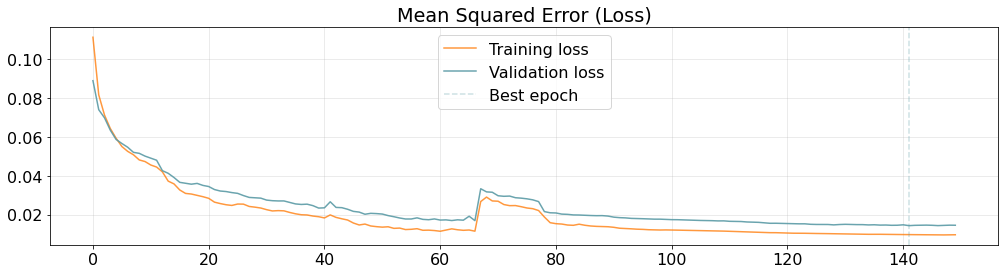

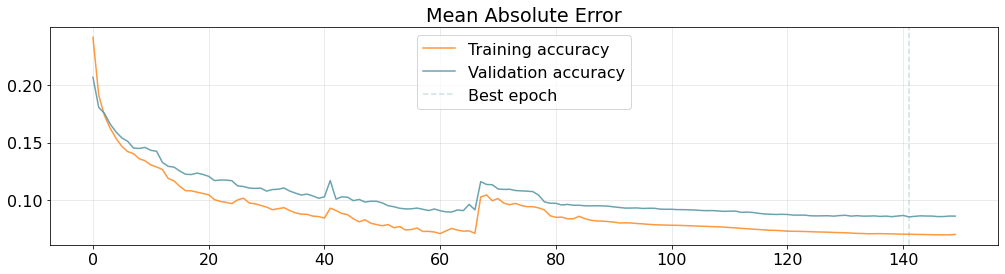

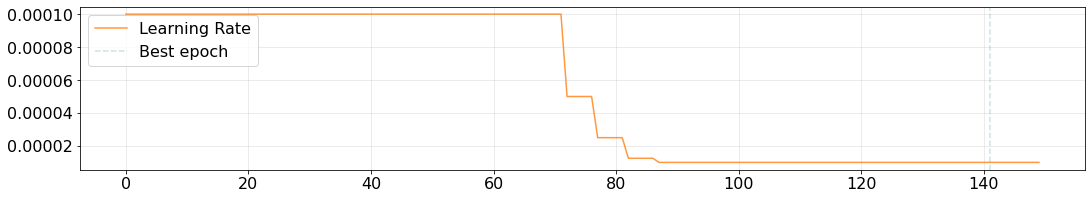

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
#model.save('Models/'+title)
model = tfk.models.load_model('Models/'+title)

In [ ]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(314, 864, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.014089518>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.089456014>)

In [ ]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

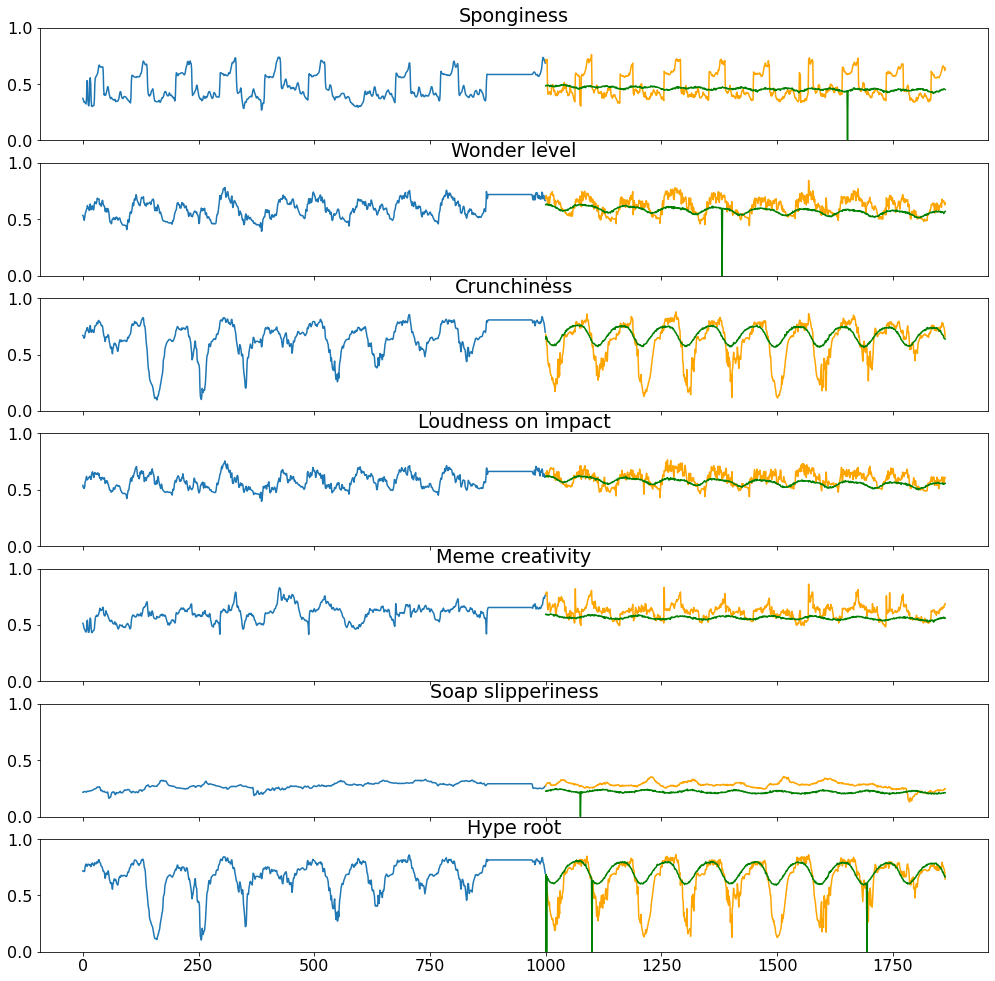

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)